In [28]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)

ATTENTION: possible bug introduced through wrong application of np.append method

In [29]:
# data = simplesim.Manager( directory="./data", filetype="nc")
# diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
# plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")
data = simplesim.Manager( directory="./resistivity-scan-0-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-0-diag", filetype="nc")

In [30]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for file in content:
    
    print( data.outfile( file), " split into ", data.count( file), " file(s)", i)
    i+=1

The database contains 6 simulations
./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc  split into  6  file(s) 0
./resistivity-scan-0-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc  split into  6  file(s) 1
./resistivity-scan-0-data/7f206f98b2083b20a6c5a69036c291e877623c7d.nc  split into  6  file(s) 2
./resistivity-scan-0-data/b4e0ad324b9df18a452b3947b4b8784b25262e6e.nc  split into  6  file(s) 3
./resistivity-scan-0-data/b826023234bf8ff7efa999f0a60ebde32a7676c7.nc  split into  4  file(s) 4
./resistivity-scan-0-data/de70eb306daa397b25ac24fefe75647e941d9a14.nc  split into  6  file(s) 5


In [31]:
config = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fx_0" : 0.125,
        "fsa" : "toroidal-average", # or "convoluted-toroidal-average"
        "diagnostics":
        [
            "fsa",
            # "fsa2d",
            "cta2d",
            # "cta2dX",  
            # "fluc2d", # these can also be computed from cta2d, fsa2d
            "ifs",
            "std_fsa",
            "ifs_lcfs",
            "ifs_norm"
        ],
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 10
    }

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [32]:
# time.sleep(3600)
for file in content :
    for i in range( 0, data.count(file)) :
        print( "Diag ", data.outfile( file), i)
        diag.create(file,i,error="display")
#         print( "Plot ", data.outfile( file), i)
#         plot.create(file,i,error="display")

Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 0
Running simulation 2e759a...e327b6.nc
Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 1
Running simulation 2e759a...7b60x1.nc
Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 2
Running simulation 2e759a...7b60x2.nc
Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 3
Running simulation 2e759a...7b60x3.nc
Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 4
Running simulation 2e759a...7b60x4.nc
Diag  ./resistivity-scan-0-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc 5
Running simulation 2e759a...7b60x5.nc
Diag  ./resistivity-scan-0-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc 0
Existing simulation 463a0f...b24298.nc
Diag  ./resistivity-scan-0-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc 1
Existing simulation 463a0f...2980x1.nc
Diag  ./resistivity-scan-0-data/463a0f4a25854a159d77c5c8742d8ff25db242

In [33]:
# def create_merged_dataset( manager, file ) :
#     datasetpaths = []
#     for i in range( 0, manager.count( file)) :
#         datasetpaths.append( manager.outfile( file, i) )
#     dataset = xr.open_mfdataset(datasetpaths, concat_dim='time', decode_times=False, join = "outer")
#     # dann brauchst du nen filter damit du die doppelten zeitschritte rausfilter kannst
#     filter = np.zeros_like(dataset["time"][:], dtype=bool)
#     filter[np.unique(dataset["time"][:], return_index=True)[1]] = True
#     return (dataset, filter)
#dann kannst du zb die zeit und masse als numpy array laden und damit hantieren
# (du kannst auch mit denen als xarray hantieren dafür gibts aber nicht alle numpy array funktionen ,
# dafür ist es wesentlich schneller!)
#time = np.asarray(dataset["time"][filter])
#mass = np.asarray(dataset["mass"][filter])


def create_merged_dataset( manager, file ) :
    datasetpaths = [manager.outfile(file,i) for i in range(manager.count(file))]
    return xfeltor.open_feltordataset( datasetpaths)


In [34]:
 # Temporary easy work with only one list element
full_content = diag.table()
content = []
content.append( full_content[0])
content.append( full_content[1])
content.append( full_content[2])
content.append( full_content[3])
content.append( full_content[4])
content.append( full_content[5])

In [35]:
min_idx_dict = {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150} # in cs/R0

ToDo 
- find

### Mass flux out of separatrix

Invert for given numerical parameters


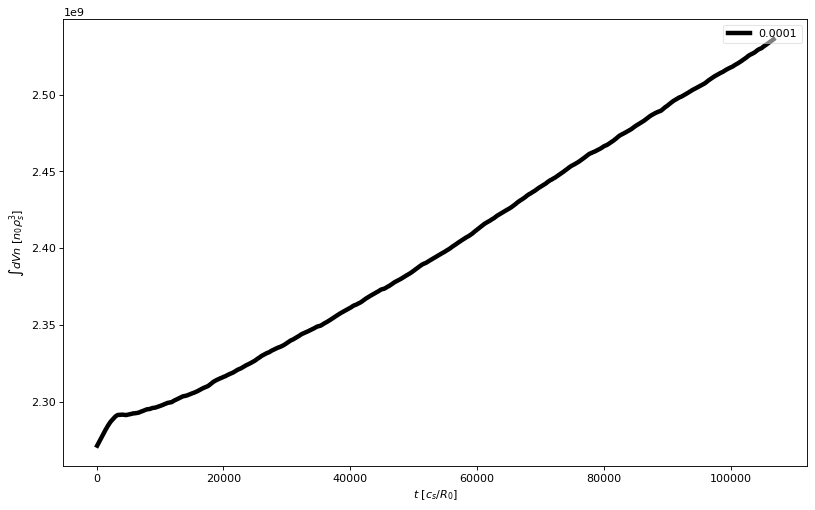

Invert for given numerical parameters


Invert for given numerical parameters


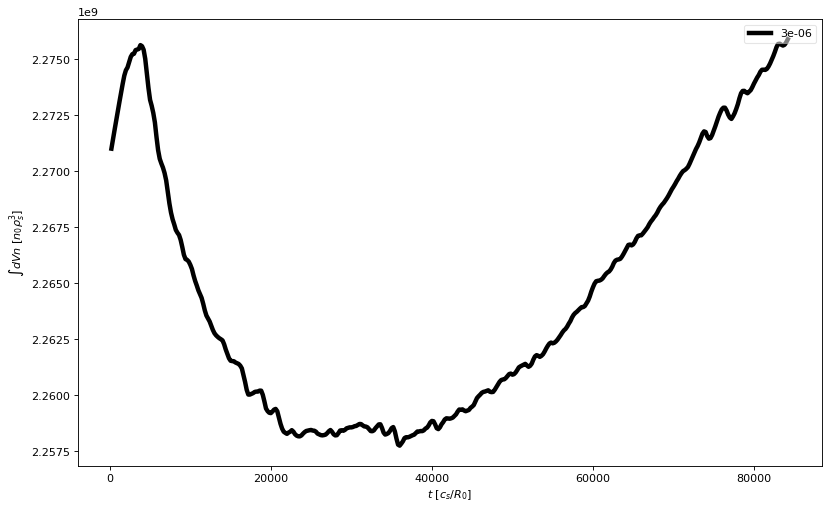

Invert for given numerical parameters


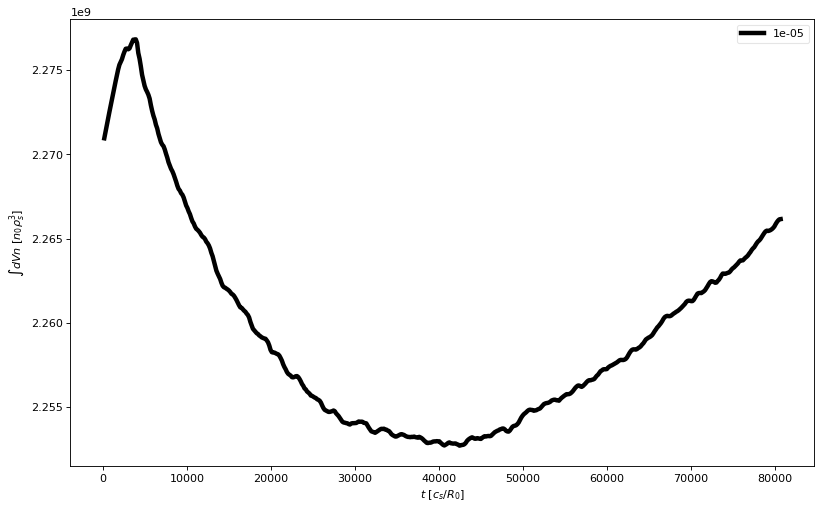

Invert for given numerical parameters


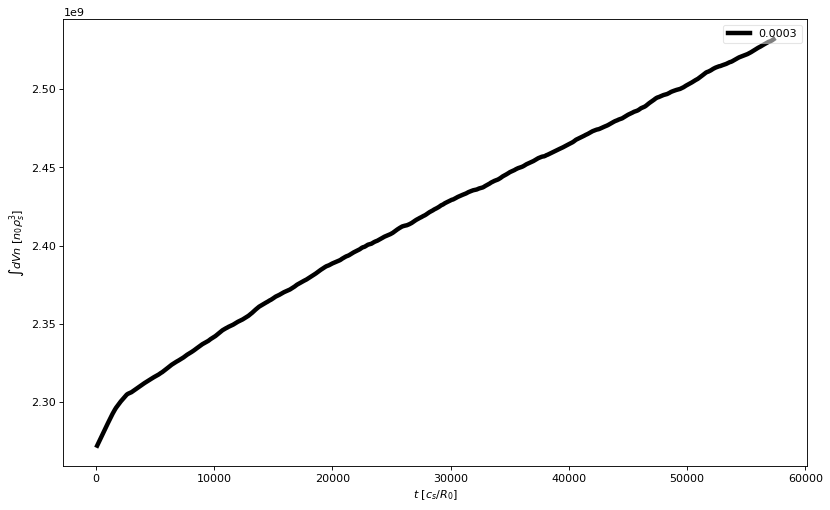

Invert for given numerical parameters


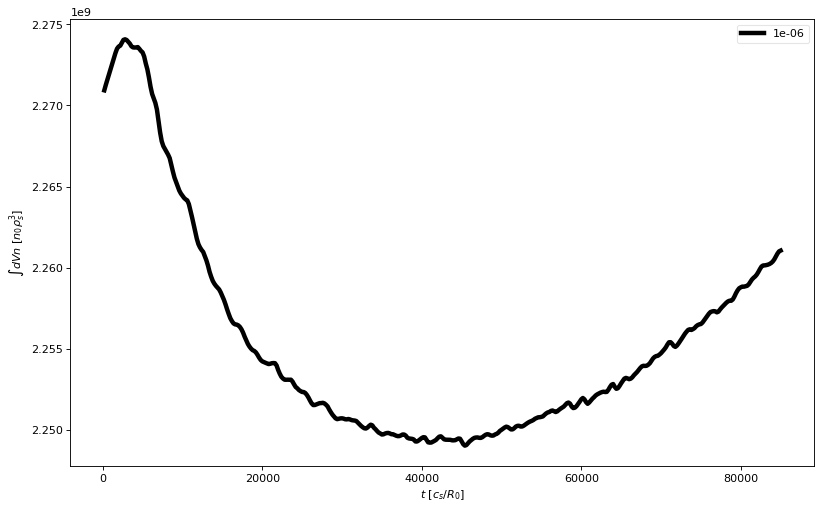

In [53]:
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    da = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][:])


    min_idx = min_idx_dict[pp["physical"]["resistivity"]]
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])

    indices = range(min_idx,np.size(time))
    plt.plot(time[1:]*timescale,mass[1:], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV n\ [n_0\rho_s^3]$")

    plt.show(   )

Invert for given numerical parameters
Average flux is 1.23e-03 pm 1.12e-04
Total average mass loss rate is 6029.5
Total mass gain by sources is 8387.4
particle confinement time = 4.02e+05


Invert for given numerical parameters
Average flux is 7.24e-04 pm 8.07e-05
Total average mass loss rate is 3562.0
Total mass gain by sources is 4193.7
particle confinement time = 6.41e+05


Invert for given numerical parameters
Average flux is 4.49e-04 pm 8.28e-05
Total average mass loss rate is 2209.2
Total mass gain by sources is 2516.2
particle confinement time = 1.03e+06


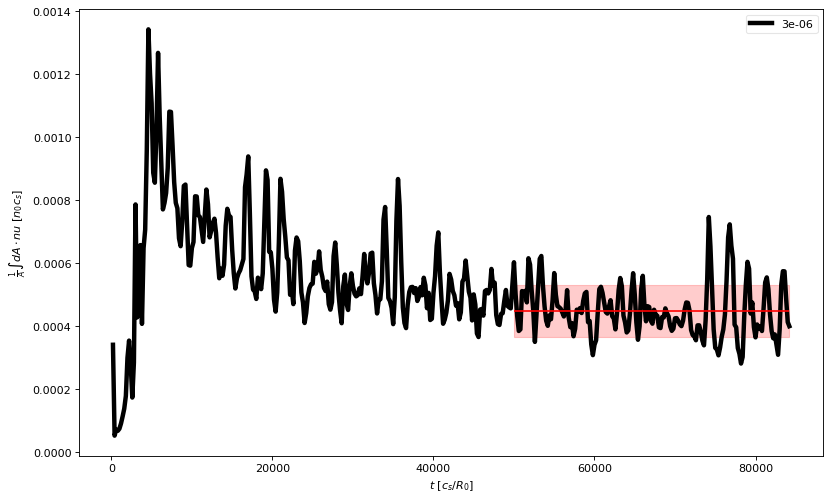

Invert for given numerical parameters
Average flux is 5.56e-04 pm 6.68e-05
Total average mass loss rate is 2732.3
Total mass gain by sources is 2935.6
particle confinement time = 8.26e+05


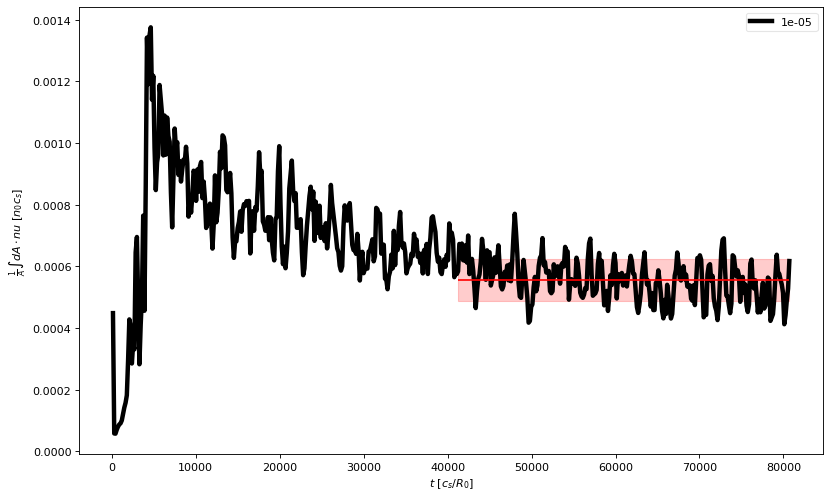

Invert for given numerical parameters
Average flux is 2.82e-03 pm 3.08e-03
Total average mass loss rate is 13893.8
Total mass gain by sources is 17807.4
particle confinement time = 1.76e+05


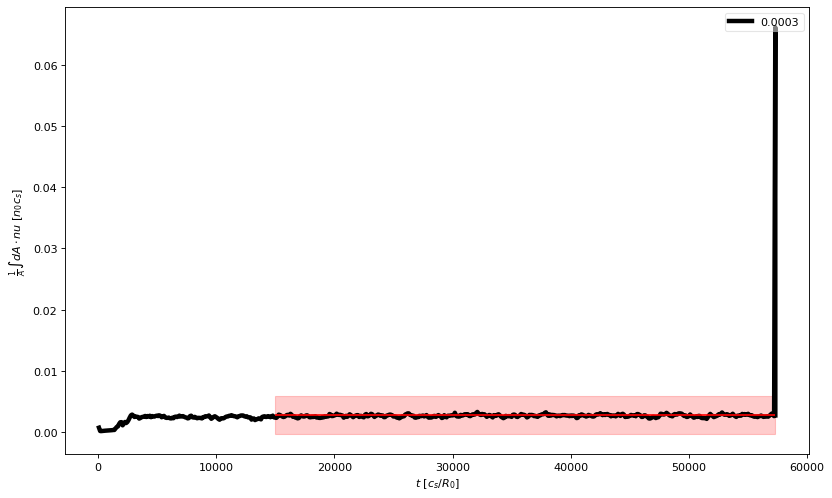

Invert for given numerical parameters
Average flux is 3.84e-04 pm 7.65e-05
Total average mass loss rate is 1887.8
Total mass gain by sources is 2096.9
particle confinement time = 1.19e+06


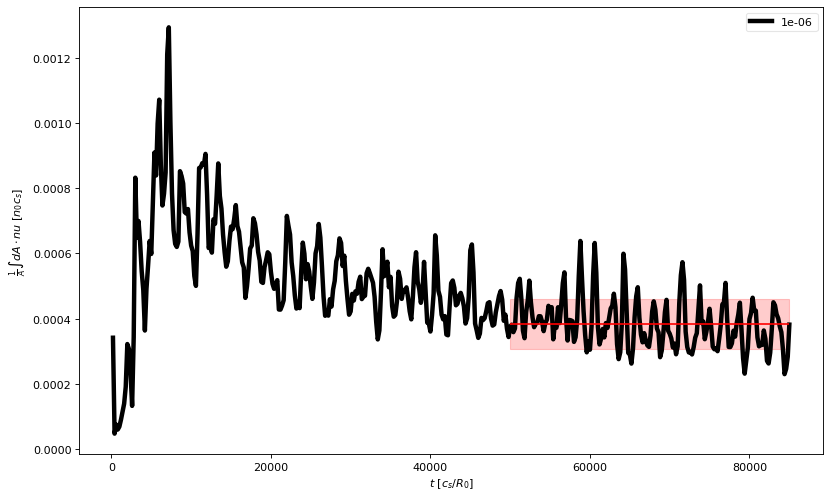

In [36]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
params_l = [] # list of parameters
average_mass_l = np.array([])
sigma_mass_l = np.array([])
average_flux_l = np.array([])
sigma_flux_l = np.array([])
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dd = Dataset( data.outfile(file), 'r')
    #da = Dataset( diag.outfile(file), "r")
    da = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
    with open( "test-file.json","w") as f:
        f.write(da.inputfile)
    #pl = nc.Dataset( plot.outfile(file), "r")
    
    #print( dset)
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    rho = da0['rho'][:]
    rho_t = da0['rho_t'][:]
    rho_p = da0['rho_p'][:]
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    area = da0['psi_area'][:]
    volume = da0['psi_vol'][:]
    min_idx = min_idx_dict[pp["physical"]["resistivity"]]
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    # jvne= dset.variables['jvneE_tt_fsa'][:,:]
    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    params_l = np.append( params_l, pp["physical"])
    average_flux_l = np.append(average_flux_l, average_jvne)
    average_mass_l = np.append(average_mass_l, average_mass)
    sigma_flux_l = np.append(sigma_flux_l, sigma_jvne)
    sigma_mass_l = np.append(sigma_mass_l, sigma_mass)
    ###################################
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    print( f"Average flux is { average_jvne/area[idx]:1.2e} pm {sigma_jvne/area[idx]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne
    indices = range(min_idx,np.size(time))
    plt.plot(time[1:]*timescale,jvne[1:]/area[idx], color='k', 
#     plt.plot(indices,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
    plt.hlines(average_jvne/area[idx], time[min_idx]*timescale, time[len(time)-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area[idx], 
                      (average_jvne+sigma_jvne)/area[idx], color='red', alpha=0.2)
#     plt.hlines(indices, time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

    plt.show(   )


Average flux  [ 6029.45127251  3562.04247745  2209.16882216  2732.313242
 13893.77118684  1887.79596155]
Sigma flux  [  552.78833908   396.87582466   407.25518127   328.64349392
 15148.22426935   376.46472011]
Average mass  [2.42280545e+09 2.28364229e+09 2.26804349e+09 2.25823648e+09
 2.45059339e+09 2.25440609e+09]
Sigma mass  [64794070.46964833  6402148.80851218  4577750.08608588  4006294.18011406
 47130598.16974908  3263803.30890714]
[5.180483649316024e-05, 3.833986870662298e-05, 2.156009257484615e-05, 2.9132000732062985e-05, 6.817899926388173e-05, 1.638212775624229e-05]
[0.0001, 3e-05, 3e-06, 1e-05, 0.0003, 1e-06]
[ 401828.51460067  641104.73257604 1026650.14411847  826492.5297393
  176380.72177413 1194200.08121146]
[ 38375.53400339  71453.24716738 189271.9315214   99421.59354835
 192335.85653055 238153.94012601]


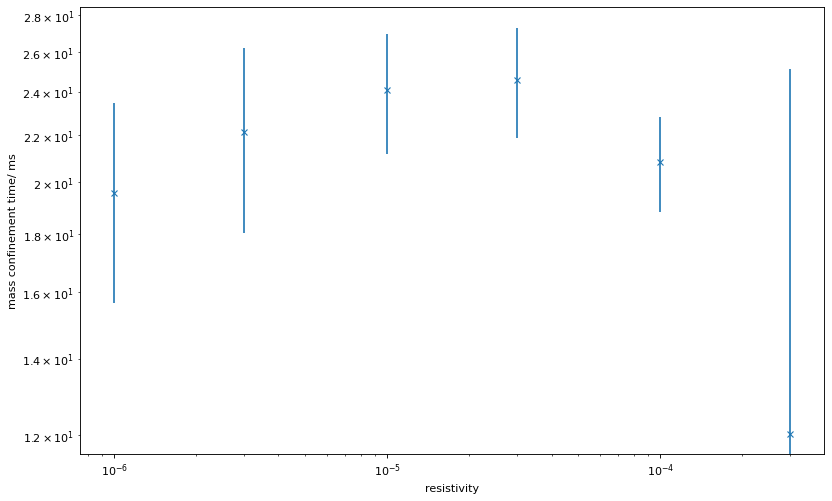

In [37]:
# print( "Resistivity ", params_l)
print( "Average flux ", average_flux_l)
print( "Sigma flux ", sigma_flux_l)
print( "Average mass ", average_mass_l)
print( "Sigma mass ", sigma_mass_l)

confinement_time = average_mass_l/average_flux_l
confinement_err = np.sqrt((sigma_mass_l/average_flux_l)**2 + (average_mass_l/average_flux_l**2*sigma_flux_l)**2)
resistivity = []
timescale = []
for pp in params_l:
    resistivity.append(pp["resistivity"])
#     timescale.append( 1./545.)# in cs/R_0 
    timescale.append(fp.omega_0_inv(**pp)*1e3 )# in ms
#     timescale = 1
print(timescale)
print(resistivity)
print(confinement_time)
print(confinement_err)
    
##### Get a linear fit 

##########################
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(resistivity, confinement_time, marker='x', ls='')
# Plot error bar 
# label axes
plt.errorbar( resistivity, confinement_time*timescale, yerr=confinement_err*timescale, marker='x', ls='')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('resistivity')
ax.set_ylabel('mass confinement time/ ms')
plt.show()

### Volume Integrated Mass conservation

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  104.79488955385386


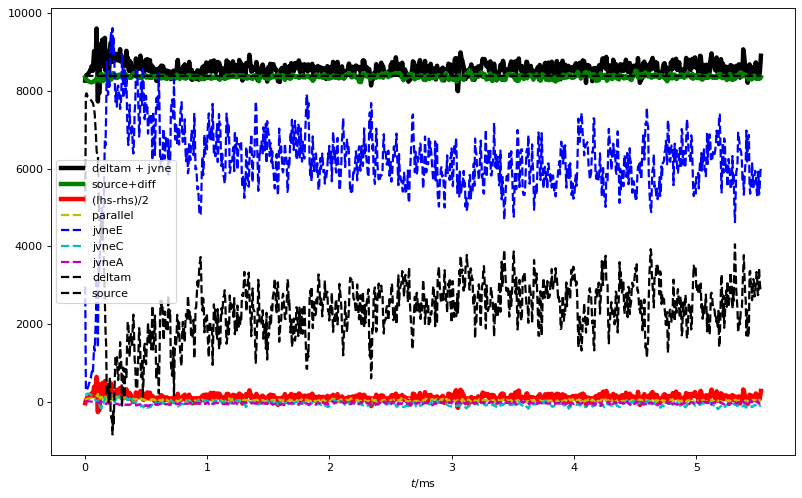

Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  95.85791921379331


Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  67.00552798602673


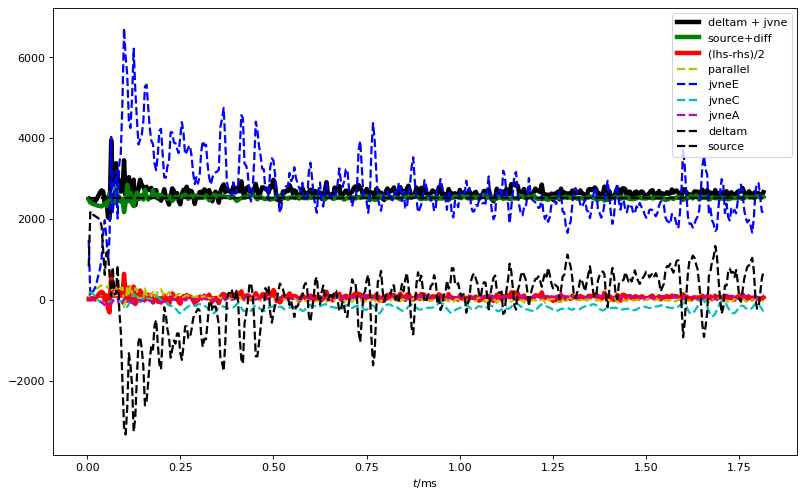

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  74.25240479604834


Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  152.59769653621746


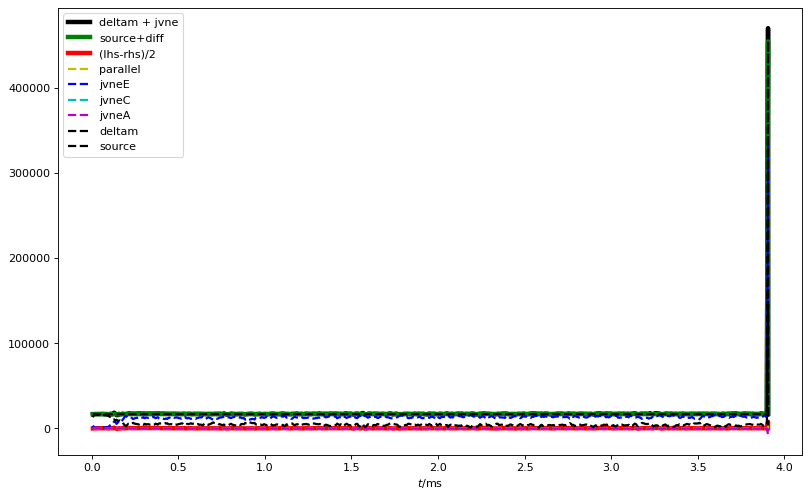

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  59.10607473982636


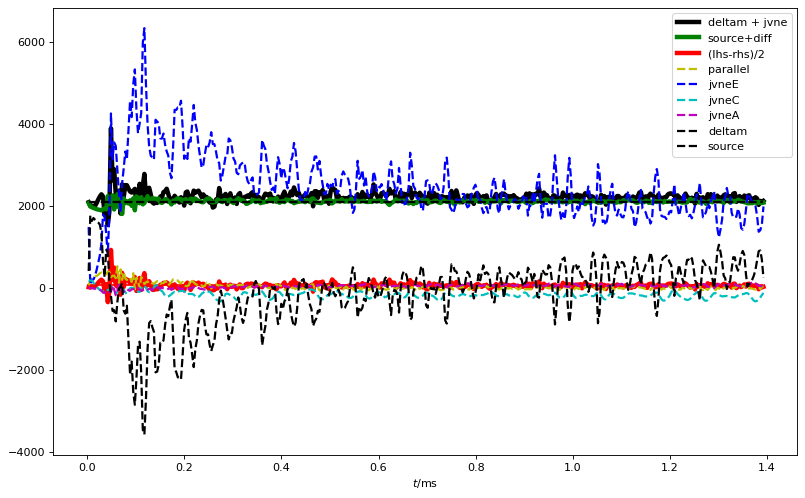

In [58]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[params["physical"]["resistivity"]]
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
    timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    mass = np.asarray(dset.variables['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltam = np.diff(masstt,axis=0)/deltat
    source = np.asarray(dset.variables['sne_tt_ifs_lcfs'][:])/deltat
    
    jvneE= np.asarray(dset['jvneE_tt_ifs_lcfs'][:])/deltat
    jvneC=np.asarray(dset['jvneC_tt_ifs_lcfs'][:])/deltat
    jvneA=np.asarray(dset['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvnepar=np.asarray(dset['divjnepar_tt_ifs_lcfs'][:])/deltat
    
    diff_perp = np.asarray(dset["lneperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(dset["lneparallel_tt_ifs_lcfs"][:])/deltat
    
#     deltamass=deltam - source
    jvne= jvneE+jvneC+jvneA#+divjvnepar
    lhs = deltam + jvne
#     rhs = jvne-diff_perp-diff_para
    rhs = source + diff_perp
    diff = (lhs - rhs)/2
   
    average_diff = np.mean(diff[1:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="deltam + jvne")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="source+diff")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs-rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    plt.plot(time[1:]*timescale,divjvnepar[1:], color='y', marker='',
             ls='--', lw = 2, label="parallel")
    plt.plot(time[1:]*timescale,jvneE[1:], color='b', marker='',
             ls='--', lw = 2, label="jvneE")
    plt.plot(time[1:]*timescale,jvneC[1:], color='c', marker='',
             ls='--', lw = 2, label="jvneC")
    plt.plot(time[1:]*timescale,jvneA[1:], color='m', marker='',
             ls='--', lw = 2, label="jvneA")
    plt.plot(time[1:]*timescale,deltam[1:], color='k', marker='',
             ls='--', lw = 2, label="deltam")
    plt.plot(time[1:]*timescale,source[1:], color='k', marker='',
             ls='--', lw = 2, label="source")

    dset.close()
    plt.legend()
    plt.xlabel(r"$t/$ms")

    plt.show(   )

## Energy conservation

Invert for given numerical parameters
Average flux is 1.04e-03 pm 1.11e-04
Total average mass loss rate is 5108.9
Total mass gain by sources is 27629.8
particle confinement time = 4.40e+01


Invert for given numerical parameters
Average flux is 4.33e-04 pm 5.89e-05
Total average mass loss rate is 2129.9
Total mass gain by sources is 13698.1
particle confinement time = 7.19e+01


Invert for given numerical parameters
Average flux is 2.13e-04 pm 3.39e-05
Total average mass loss rate is 1048.8
Total mass gain by sources is 8118.5
particle confinement time = 8.08e+01


Invert for given numerical parameters
Average flux is 3.13e-04 pm 4.67e-05
Total average mass loss rate is 1538.0
Total mass gain by sources is 9473.3
particle confinement time = 7.38e+01


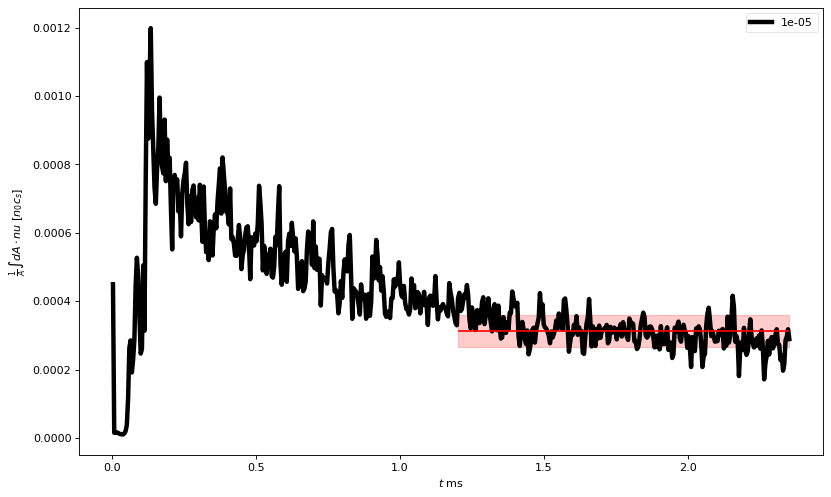

Invert for given numerical parameters
Average flux is 3.55e-03 pm 4.05e-03
Total average mass loss rate is 17483.0
Total mass gain by sources is 57503.9
particle confinement time = 1.67e+01


Invert for given numerical parameters
Average flux is 1.60e-04 pm 3.66e-05
Total average mass loss rate is  788.8
Total mass gain by sources is 6722.1
particle confinement time = 8.08e+01


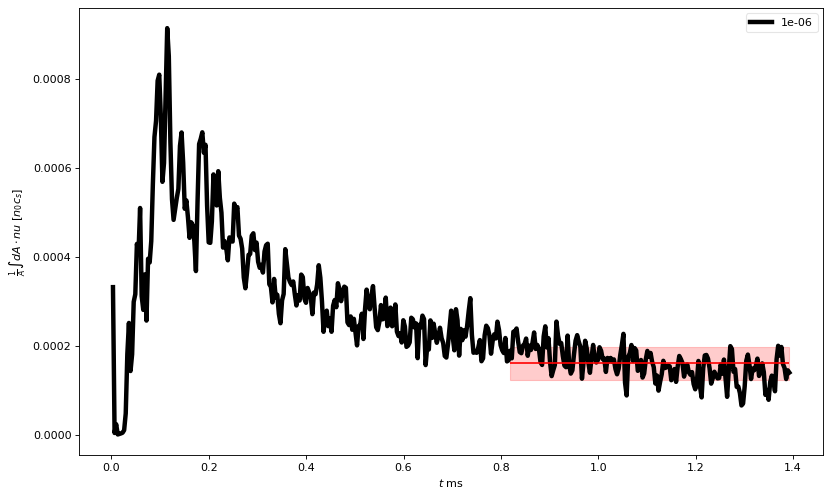

In [39]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
params_l = [] # list of parameters
average_energy_l = np.array([])
sigma_energy_l = np.array([])
average_Eflux_l = np.array([])
sigma_Eflux_l = np.array([])

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')

    da = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
 
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    rho = da0['rho'][:]
    rho_t = da0['rho_t'][:]
    rho_p = da0['rho_p'][:]
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    area = da0['psi_area'][:]
    volume = da0['psi_vol'][:]
    min_idx = min_idx_dict[pp['physical']['resistivity']]
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = da.variables['jvee_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jvei_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveea_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveia_tt_ifs_lcfs'][:]/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    params_l = np.append( params_l, pp["physical"])
    average_Eflux_l = np.append(average_Eflux_l, average_jvne)
    average_energy_l = np.append(average_energy_l, average_mass)
    sigma_Eflux_l = np.append(sigma_Eflux_l, sigma_jvne)
    sigma_energy_l = np.append(sigma_energy_l, sigma_mass)
    ###################################
    source =da.variables['see_tt_ifs_lcfs'][:]/deltat
    source+=da.variables['sei_tt_ifs_lcfs'][:]/deltat
    average_source = source[min_idx:].mean()

    print( f"Average flux is { average_jvne/area[idx]:1.2e} pm {sigma_jvne/area[idx]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    confinement_time = np.append( confinement_time, average_mass/average_jvne*timescale )
    tau = mass/jvne

    plt.plot(time[1:]*timescale,jvne[1:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
    plt.hlines(average_jvne/area[idx], time[min_idx]*timescale, time[len(time)-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area[idx], 
                      (average_jvne+sigma_jvne)/area[idx], color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

    plt.show(   )


Average flux  [ 5108.88862318  2129.91222099  1048.80430528  1537.9868407
 17483.00018369   788.81758434]
Sigma flux  [  547.83264937   289.8113681    166.52481015   229.79232375
 19897.28398713   179.8737989 ]
Average energy  [4.33477893e+09 3.99623826e+09 3.92979501e+09 3.89564050e+09
 4.28647348e+09 3.89242744e+09]
Sigma energy  [2.05219262e+08 3.77865293e+07 3.74794224e+07 4.03634603e+07
 1.29814381e+08 3.30064500e+07]
[5.180483649316024e-05, 3.833986870662298e-05, 2.156009257484615e-05, 2.9132000732062985e-05, 6.817899926388173e-05, 1.638212775624229e-05]
[0.0001, 3e-05, 3e-06, 1e-05, 0.0003, 1e-06]
[ 848477.86956352 1876245.52041853 3746928.75800592 2532947.87333946
  245179.51373097 4934508.9635381 ]
[  99456.15243605  255911.3077792   595994.15092763  379359.44754506
  279135.91693439 1125992.09007036]


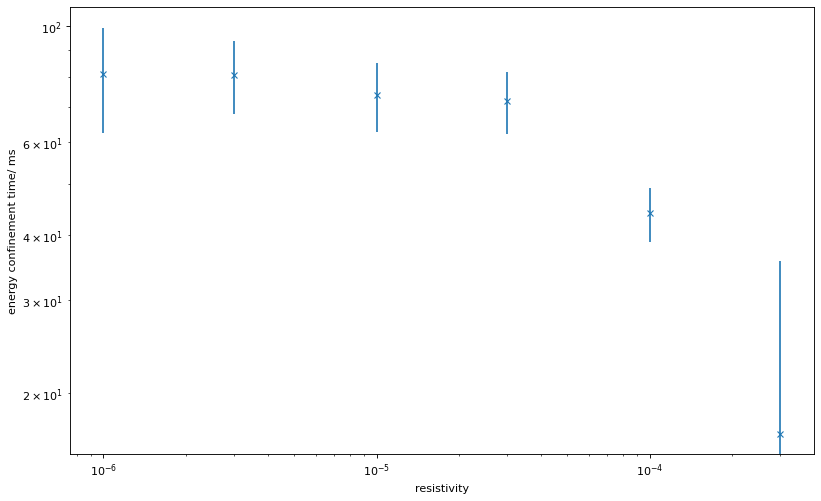

In [40]:
# print( "Resistivity ", params_l)
print( "Average flux ", average_Eflux_l)
print( "Sigma flux ", sigma_Eflux_l)
print( "Average energy ", average_energy_l)
print( "Sigma energy ", sigma_energy_l)

confinement_time = average_energy_l/average_Eflux_l
confinement_err = np.sqrt((sigma_energy_l/average_Eflux_l)**2 + (average_energy_l/average_Eflux_l**2*sigma_Eflux_l)**2)
resistivity = []
timescale = []
for pp in params_l:
    resistivity.append(pp["resistivity"])
#     timescale.append( 1./545.)# in cs/R_0 
    timescale.append(fp.omega_0_inv(**pp)*1e3 )# in ms
#     timescale = 1
print(timescale)
print(resistivity)
print(confinement_time)
print(confinement_err)
    
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(resistivity, confinement_time, marker='x', ls='')
# Plot error bar 
# label axes
plt.errorbar( resistivity, confinement_time*timescale, yerr=confinement_err*timescale, marker='x', ls='')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('resistivity')
ax.set_ylabel('energy confinement time/ ms')
plt.show()

Let's be careful with too general conclusions about the two regimes. The equations are fairly basic with isothermal assumption. There could still be hidden systematic numerical issues (e.g. turbulence in low resistivity does not reach core region?)

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -198.72524511837236


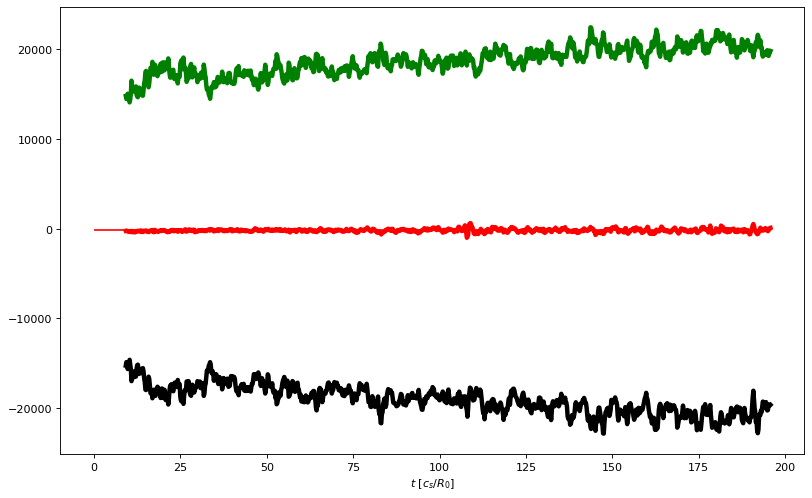

Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -48.21700151825656


Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  107.90719263800193


Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  58.896661360190045


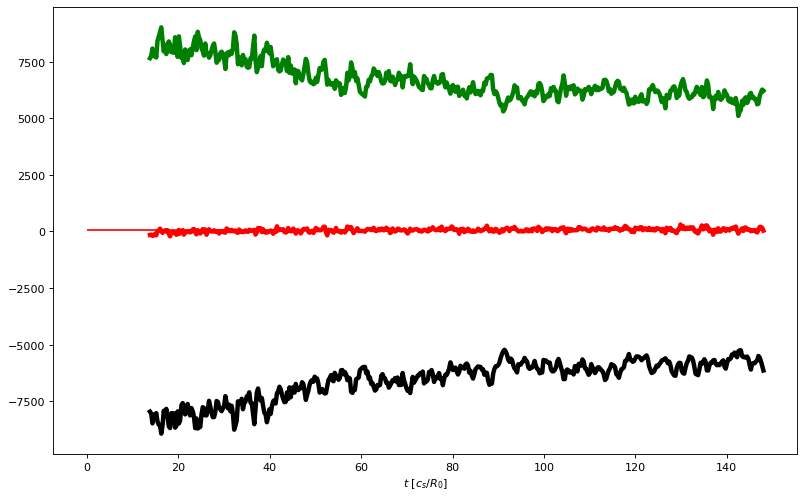

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -486.43568165440115


Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  136.52145586740926


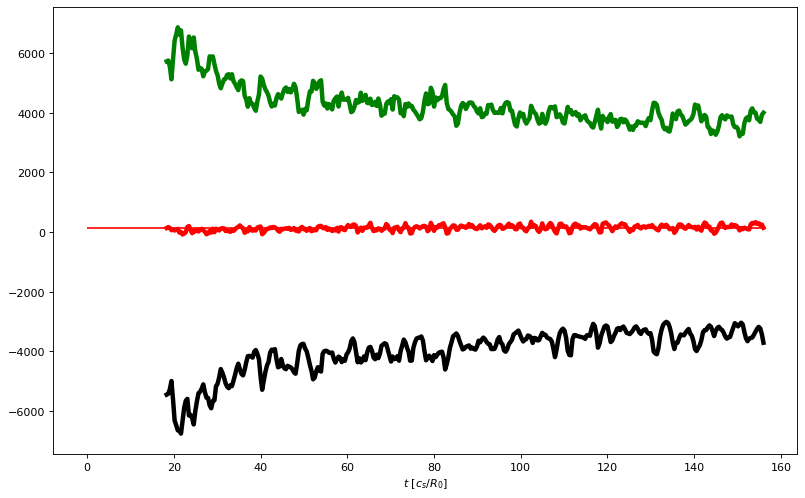

In [41]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(dset['ue2_ifs_lcfs'][:])
    mass+=np.asarray(dset['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(dset['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(dset['neue2_ifs_lcfs'][:])
    mass+=np.asarray(dset['niui2_ifs_lcfs'][:])
    mass+=np.asarray(dset['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source =np.asarray(dset.variables['see_tt_ifs_lcfs'][:])/deltat
    source+=np.asarray(dset.variables['sei_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne = np.asarray(dset.variables['jvee_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jvei_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jveea_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jveia_tt_ifs_lcfs'][:])/deltat

    diff_perp = np.asarray(dset.variables["leeperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(dset.variables["leeparallel_tt_ifs_lcfs"][:])/deltat
    diff_perp+= np.asarray(dset.variables["leiperp_tt_ifs_lcfs"][:])/deltat
    diff_para+= np.asarray(dset.variables["leiparallel_tt_ifs_lcfs"][:])/deltat
    resistive = np.asarray(dset.variables['resistivity_tt_ifs_lcfs'][:])/deltat
    rhs = jvne-diff_perp-diff_para-resistive
    diff = (deltamass + rhs)/2
    min_idx = 50
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[min_idx:]*timescale,deltamass[min_idx:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[min_idx:]*timescale,rhs[min_idx:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[min_idx:]*timescale,diff[min_idx:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")

    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

### Average FSA Mass conservation 

Resistivity = 0.0001
Average diff =  -1.2129830947451975e-06
Average std  =  1.4463373562993187e-05
Resistivity = 3e-05
Average diff =  -2.0451504394536148e-06
Average std  =  1.8563047743271235e-05
Resistivity = 3e-06
Average diff =  -1.0937601976569085e-06
Average std  =  1.3155219840355359e-05
Resistivity = 1e-05
Average diff =  -1.0077055171892544e-06
Average std  =  1.5600864337756163e-05
Resistivity = 0.0003
Average diff =  2.4158945147765626e-06
Average std  =  2.0044670041149595e-05
Resistivity = 1e-06
Average diff =  7.581830159731254e-07
Average std  =  1.2351615511078421e-05


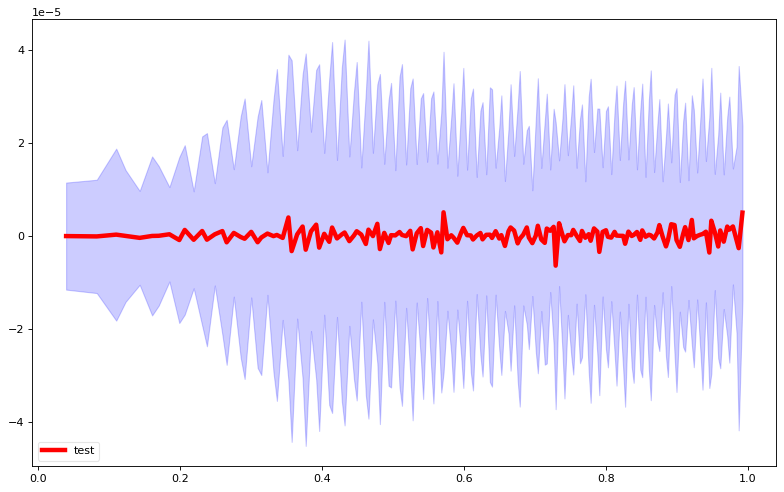

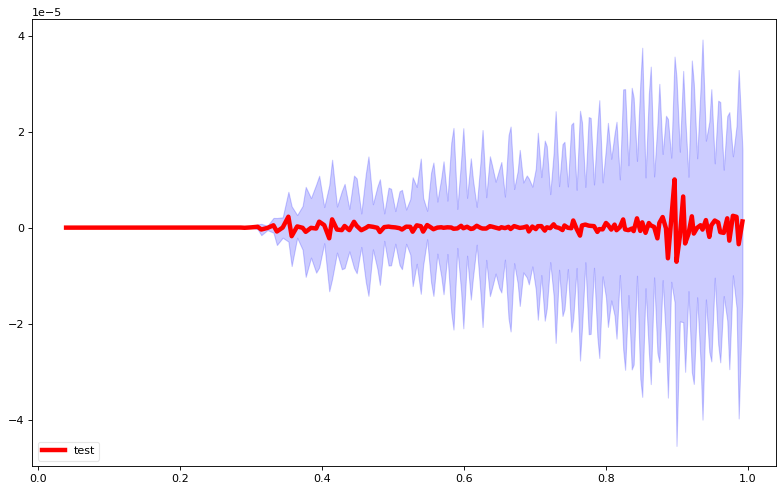

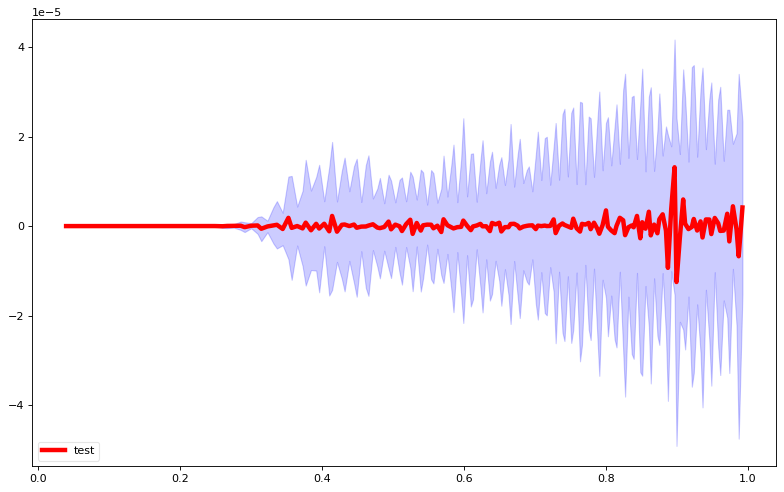

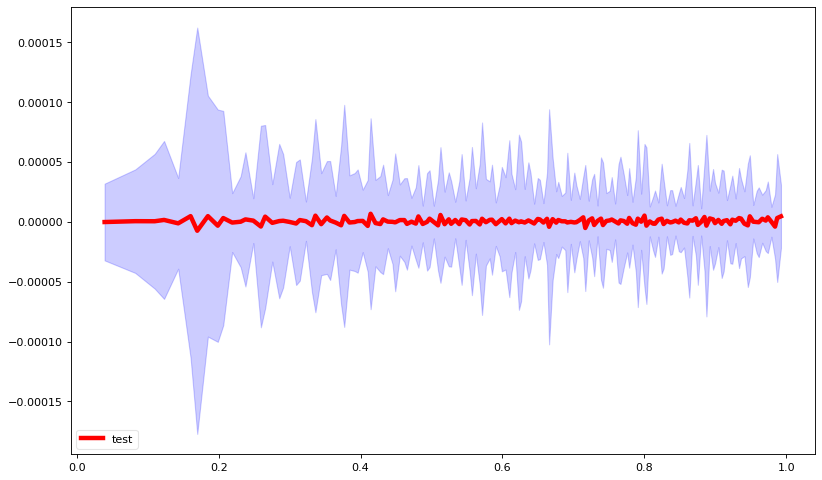

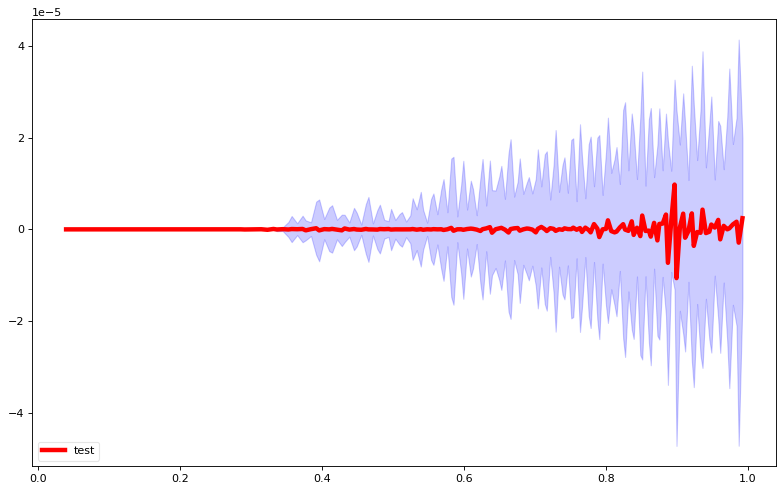

In [42]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    
    dset = create_merged_dataset( diag, file)
    params = json.loads(dset.inputfile)
    mass =np.asarray(dset.variables['electrons_fsa'][:,:])
    time = np.asarray(dset.variables['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(dset.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4, label = 'test')
    plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()

### Local Mass conservation on LCFS

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -0.0006610757866361277
Average std  =  0.007882538591831295
Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -0.0011146069895022212
Average std  =  0.010116861020082822
Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -0.0005960993077230167
Average std  =  0.007169594812993675
Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -0.0005491995068681432
Average std  =  0.00850247106407711
Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  0.0009894748941788457
Average std  =  0.007345113437856183
Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  0.00041320974370535424
Average std  =  0.0067316304535377375


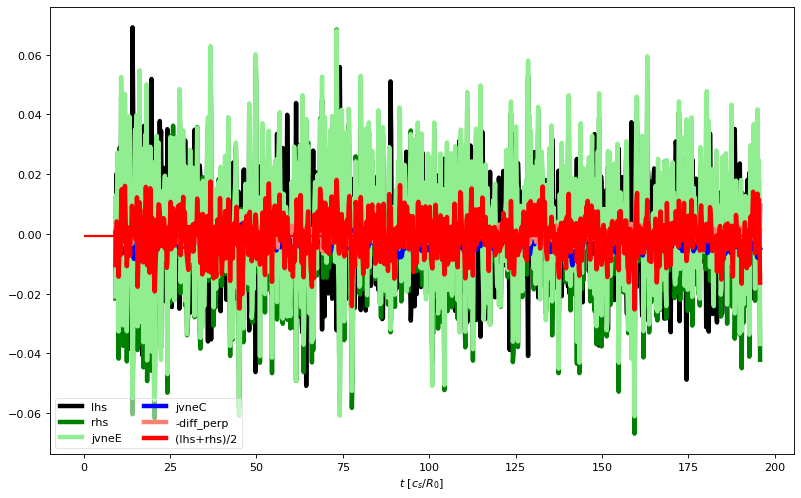

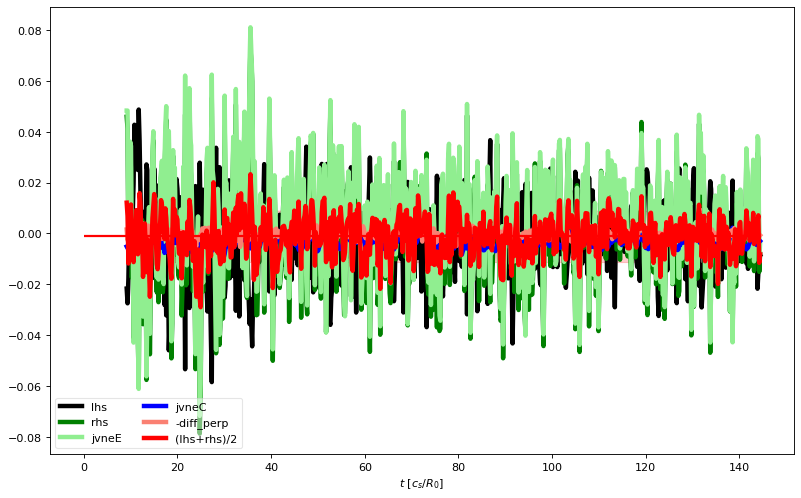

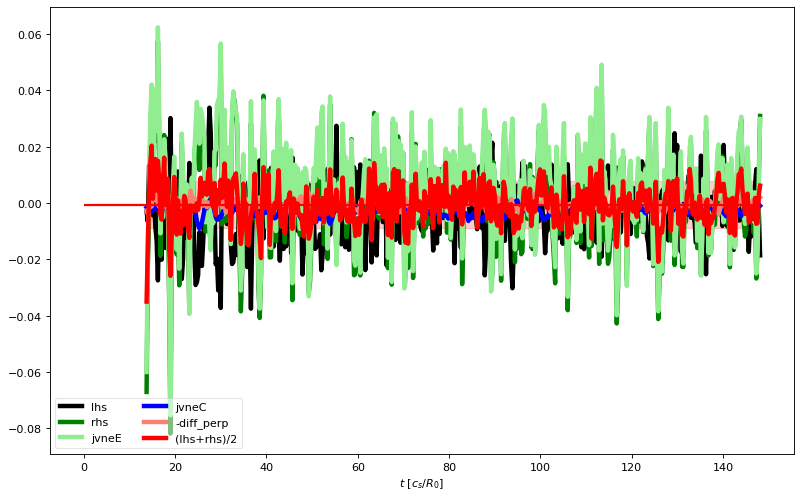

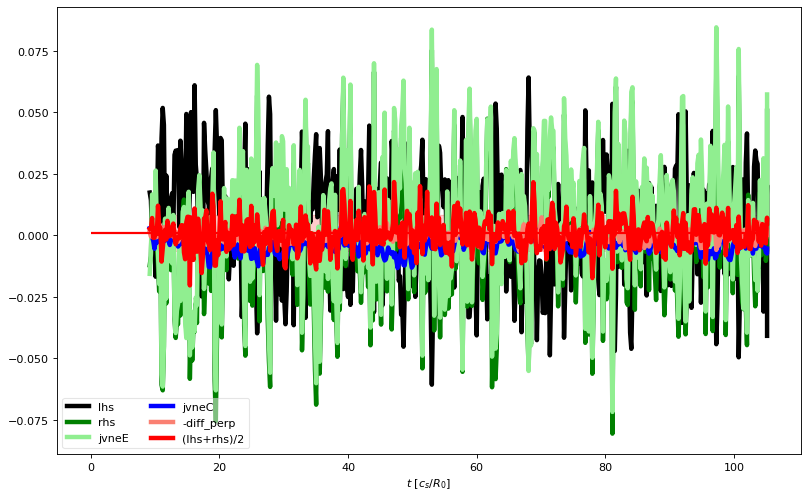

In [43]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params= json.loads(dset.inputfile)
    mass =np.asarray(dset.variables['electrons_fsa'][:,:])
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    time = np.asarray(dset.variables['time'][:])*timescale
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(dset.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    min_idx = 50
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=4, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 4,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 4, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 4, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 4,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 4,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

Invert for given numerical parameters
Resistivity = 0.0001
Dataset length  1068
Average region  36.69724770642202 195.7798165137615
Invert for given numerical parameters
Resistivity = 3e-05
Dataset length  788
Average region  91.74311926605505 144.40366972477065
Invert for given numerical parameters
Resistivity = 3e-06
Dataset length  422
Average region  91.74311926605505 154.4954128440367
Invert for given numerical parameters
Resistivity = 1e-05
Dataset length  539
Average region  75.68807339449542 148.07339449541286
Invert for given numerical parameters
Resistivity = 0.0003
Dataset length  575
Average region  27.522935779816514 105.14436992288653
Invert for given numerical parameters
Resistivity = 1e-06
Dataset length  426
Average region  91.74311926605505 155.9633027522936


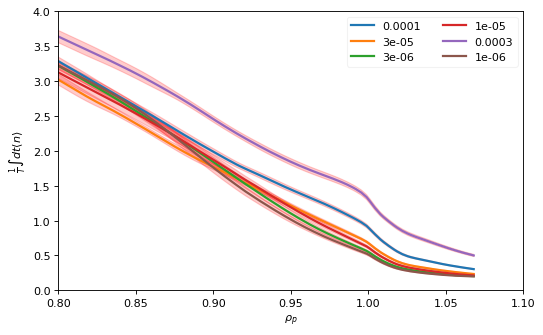

In [44]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :


    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )

    time = np.asarray(dset.variables['time'][:])
    min_idx = min_idx_dict[params['physical']['resistivity']]
    density =dset.variables['electrons_fsa'][:]
    source = dset.variables['sne_tt_fsa'][:]
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Dataset length ", len(time))
    print( "Average region ", time[min_idx]*timescale, time[len(time)-1]*timescale)
    avg_density=density[min_idx:len(time)-1].mean(axis=0)
    std_density=density[min_idx:len(time)-1].std(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( rho_p, avg_density, ls='-', lw=2, label=f'{params["physical"]["resistivity"]}')
    # plt.plot( rho_t, density[len(time)-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t, avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t,   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( rho_p,   -psi_p/2+1, ls='--', color = 'k')
    plt.fill_between( rho_p, (avg_density-std_density), 
                      (avg_density+std_density), color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    dset.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0.8,1.1)
plt.ylim(0,4)
plt.show(  )

### Vorticity accuracy on LCFS

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0001
Average diff =  2.466283967634978e-07
Average std  =  1.0396396555812737e-06


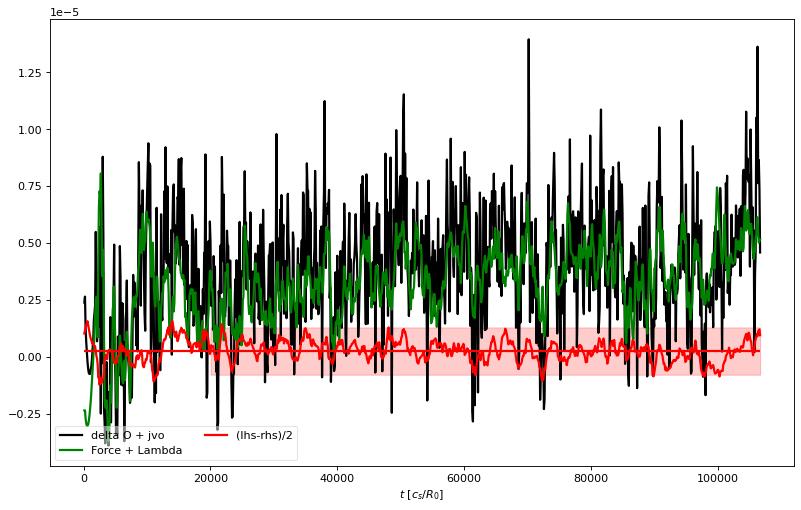

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 3e-05
Average diff =  -1.9851020263740847e-08
Average std  =  9.627977303930211e-07


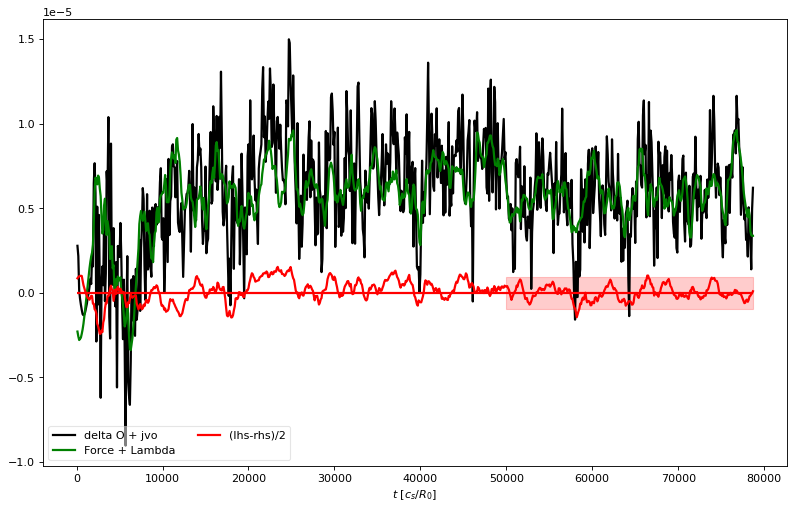

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 3e-06
Average diff =  -4.230502166908733e-07
Average std  =  7.603247152391759e-07


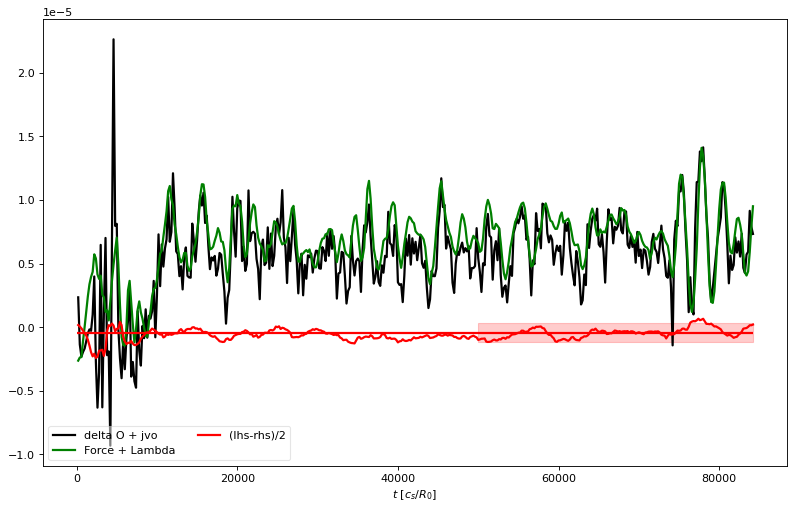

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-05
Average diff =  -2.896524907923258e-07
Average std  =  7.865039130722585e-07


Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0003
Average diff =  8.506725848168261e-07
Average std  =  8.543249351476292e-07


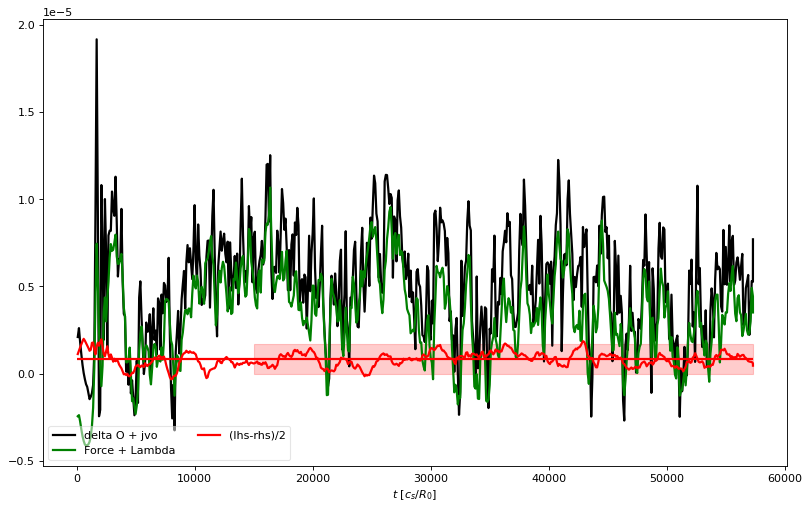

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-06
Average diff =  -6.086569119721767e-07
Average std  =  5.891185386358538e-07


In [71]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
    min_idx = min_idx_dict[params["physical"]["resistivity"]]
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0   
#     vorticity = dset['vorticity_fsa'][:,:]
#     el = dset['electrons_ifs'][:,:]
#     ions = dset['ions_ifs'][:,:]
#     dvdpsip=dset['dvdpsi'][:]
#     vorticity = (el-ions)/dvdpsip
    vorticity =np.asarray(dset['oexbe_fsa'][:,:])
    # vorticity+=dset['odiae_fsa'][:,:]
    # vorticity/=dset['electrons_fsa'][:,:]
    tttvorticity=np.append(np.zeros((1,len(rho_t))),vorticity, axis=0)
    deltavorticity = np.diff(tttvorticity,axis=0)/deltat[:,None]
    jvoE= np.asarray(dset['jvoexbe_tt_ifs'][:,:])/deltat[:,None]
    jvoD= np.asarray(dset['jvoexbeUD_tt_ifs'][:,:])/deltat[:,None]
    # jvoD= dset.variables['jvodiaeUE_tt_ifs'][:,:]/deltat[:,None]
    maxwell= np.asarray(dset['jvoapar_tt_ifs'][:,:])/deltat[:,None]
    jvoA= np.asarray(dset['jvoexbApar_tt_ifs'][:,:])/deltat[:,None]
    # jvoA= dset['jvodiaApar_tt_ifs'][filter,:]/deltat[:,None]
    jvo = jvoE + jvoD + maxwell + jvoA
    force = -np.asarray(dset["socurve_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvi_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappae_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappai_tt_fsa"][:,:])/deltat[:,None]
    # force2 = -dset["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
    # source = dset["sosne_tt_fsa"][:,:]/deltat[:,None]
    # source+= dset["sospi_tt_fsa"][:,:]/deltat[:,None]
    lamb = np.asarray(dset["loexbe_tt_fsa"][:,:])/deltat[:,None]
    #lamb = dset['lneperp_tt_ifs'][:,:]/deltat[:,None]

    #lamb = lamb/dvdpsip[None,:]
    lhs = deltavorticity + jvo
    rhs = -force+lamb#-source
    # diff = +deltavorticity + rhs
    diff = (lhs-rhs)/2
    # delayed_diff = (deltavorticity[0:-1,:]+rhs[1:,:])/2
    average_diff = np.mean( diff[min_idx:], axis=0)
    average_std = np.std( diff[min_idx:], axis=0)
    # rhs = rhs - 2*average_diff[None, :]
    # diff = ( deltavorticity + rhs)/2
    
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    print( "Index 167 vs lcfs", lcfs)
    idx= lcfs
    print( idx)
    print( rho_t[idx])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[1:],lhs[1:,idx], color='k', marker='',
              ls='-',lw=2,markeredgecolor='k', markersize=8, label="delta O + jvo")
    plt.plot(time[1:],rhs[1:,idx], color='g', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="Force + Lambda")
    plt.plot(time[1:],np.convolve(diff[1:,idx],np.ones(10)/10, mode='same'), color='r', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="(lhs-rhs)/2")
#     plt.plot(time[1:],jvoE[1:,idx], color='salmon', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvoE")
# #     plt.plot(time[1:],jvoD[1:,idx], color='lightblue', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvoD")
# #     plt.plot(time[min_idx:],-source[min_idx:,idx], color='crimson', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="-source")
#     plt.plot(time[1:],force[1:,idx], color='y', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
# #     plt.plot(time[1:],jvoA[1:,idx], color='orange', marker='',
# #               ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvoA")
#     plt.plot(time[1:],maxwell[1:,idx], color='c', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="Maxwell")
#     plt.plot(time[1:],-lamb[1:,idx], color='lightyellow', marker='',
#               ls='--', lw = 2, markeredgecolor='k', markersize=8, label="-lambda")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    # print(time[len(time)-1])
    # idx = np.where( time[np.where( time < 9356)]>9354)
    # print( idx[0][0] )
    # plt.plot( rho_t, force[ idx[0][0],: ], color='y', label = "force")
    # plt.plot( rho_t, jvo[ idx[0][0],: ], color='r', label = "jvo")
    # plt.plot( rho_t, deltavorticity[ idx[0][0],: ], color='g', label = "dO")
    
    
    # plt.plot( rho_t, average_diff, ls = '-', color=v[0], lw = 4, label = v[1])
    # plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
    #                   average_diff[0:167]+average_std[0:167], color=v[0], alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    # plt.xlabel(r"$\rho_t$")
    # plt.xlim(0,6)
    # plt.ylabel(r"$\int dV \Omega_E$")
    #plt.xlim(6360,6400)
    # plt.xlim(0,1.0)
    # plt.ylim(-2e-2,2e-2)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show(   )

## Ion toroidal momentum plot

Invert for given numerical parameters


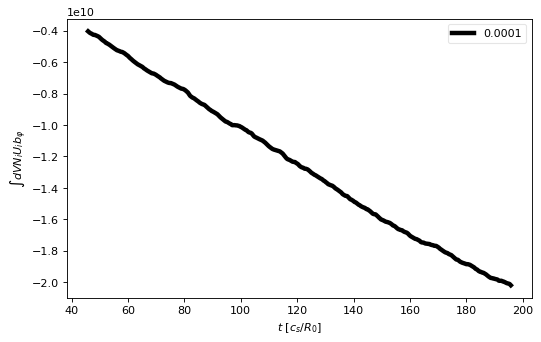

Invert for given numerical parameters


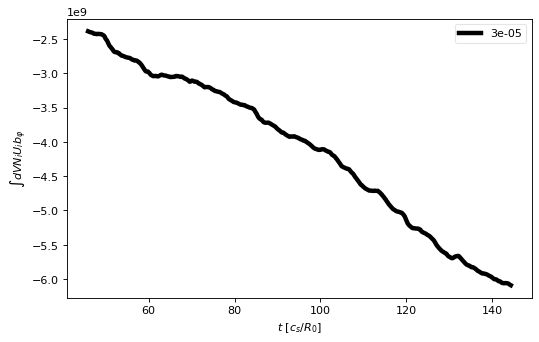

Invert for given numerical parameters


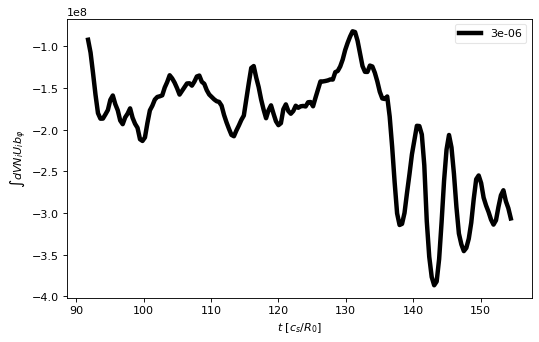

Invert for given numerical parameters


Invert for given numerical parameters


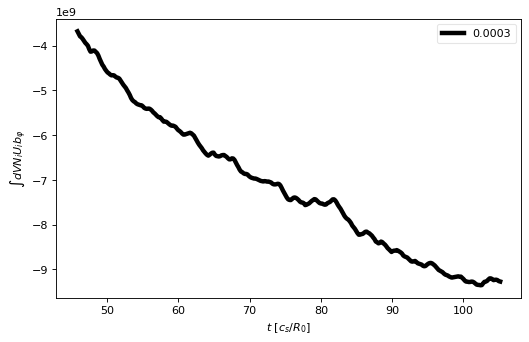

Invert for given numerical parameters


In [73]:
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]*timescale
    
    niuibphi = dset.variables['niuibphi_ifs_lcfs'][:]
    oexb = dset.variables['oexbi_ifs_lcfs'][:]

    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{params["physical"]["resistivity"]}')
#     plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
#          marker='',ls='-', lw=4,markeredgecolor='k', markersize=8
#          )
#     plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
#          marker='',ls='-', lw=4,markeredgecolor='r', markersize=8
#          )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV  N_iU_ib_\varphi$")

    plt.show(   )

### Ion toroidal momentum accuracy

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -294982.93579150527


Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -185939.40253672903


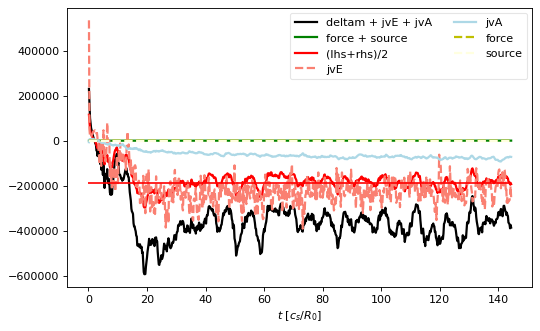

Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -129070.39504918017


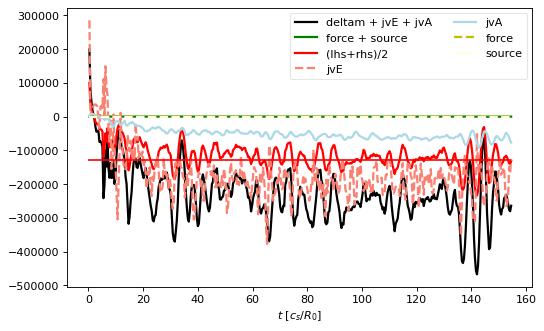

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -148307.79649932412


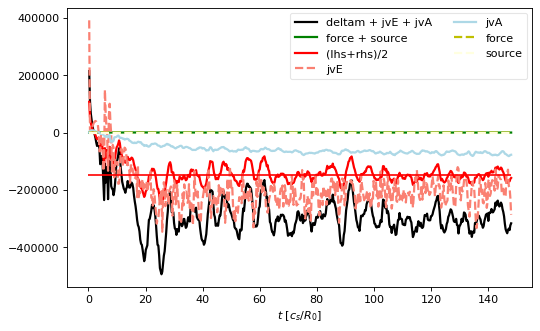

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -354079.8881887614


Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -113664.97842648251


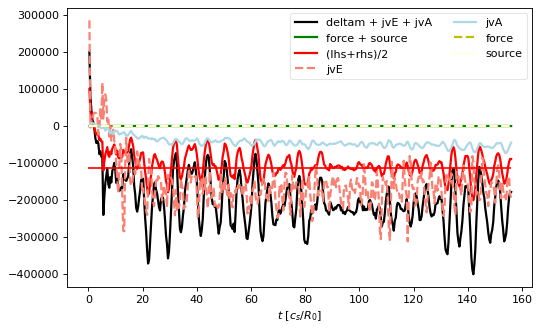

In [77]:
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    
    
    mass =np.asarray(dset.variables['niuibphi_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(dset.variables['sparsnibphi_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(dset['jvparbphiexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(dset['jvparbphiApar_tt_ifs_lcfs'][:])/deltat
    
    force = -np.asarray(dset.variables["socurve_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvi_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvkappae_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvkappai_tt_ifs_lcfs"][:])/deltat
    lhs = deltam + jvneE + jvneA
    rhs = -force + source
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[params['physical']['resistivity']]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvE + jvA")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force + source")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,force[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Ion parallel momentum

Invert for given numerical parameters
Resistivity = 0.0001
timescale = 0.001834862385321101
Average diff =  -160.8261195553935


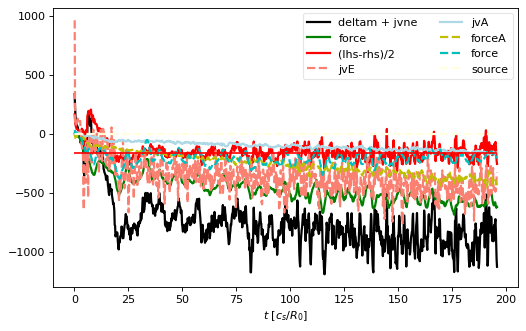

Invert for given numerical parameters
Resistivity = 3e-05
timescale = 0.001834862385321101
Average diff =  -67.37092641408046


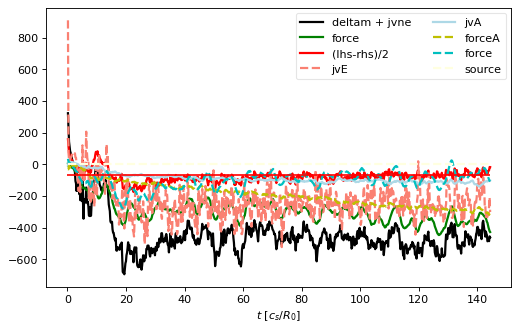

Invert for given numerical parameters
Resistivity = 3e-06
timescale = 0.001834862385321101
Average diff =  -55.1555840894456


Invert for given numerical parameters
Resistivity = 1e-05
timescale = 0.001834862385321101
Average diff =  -69.11298494402736


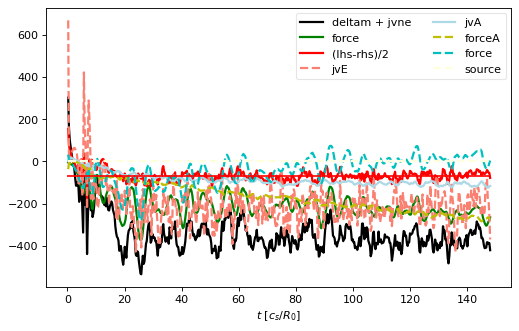

Invert for given numerical parameters
Resistivity = 0.0003
timescale = 0.001834862385321101
Average diff =  -132.51834248357048


Invert for given numerical parameters
Resistivity = 1e-06
timescale = 0.001834862385321101
Average diff =  -46.07121860356081


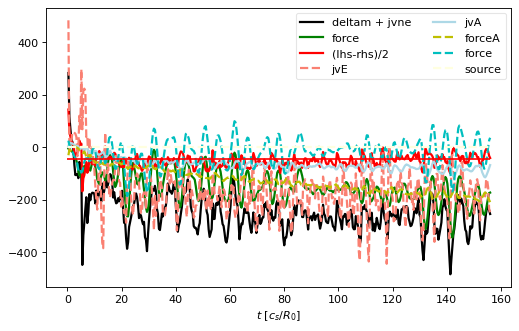

In [96]:
# content = []
# content.append( full_content[3])
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    
    mass =np.asarray(dset['niui_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(dset['sparsni_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(dset['jvparexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(dset['jvparApar_tt_ifs_lcfs'][:])/deltat
    jvneD = np.asarray(dset['jvpardiai_tt_ifs_lcfs'][:])/deltat
    jvneK = np.asarray(dset['jvparkappai_tt_ifs_lcfs'][:])/deltat
#     divjpar = np.asarray(dset['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(dset['divjpari_tt_ifs_lcfs'][:])/deltat
    force  = np.asarray(dset["sparmirrore_tt_ifs_lcfs"][:])/deltat
    force += np.asarray(dset["sparmirrori_tt_ifs_lcfs"][:])/deltat
    
    forceA = ( 1. + params["physical"]["tau"])*np.asarray(dset['sparmirrorAe_tt_ifs_lcfs'][:])/deltat # !! important part !!
    lhs = deltam + jvneE + jvneA + jvneD + jvneK #+ divjpar
    rhs = force  + forceA
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[params['physical']['resistivity']]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print(f'timescale = {timescale}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvne")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs-rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,forceA[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="forceA")
    plt.plot(time[1:]*timescale,force[1:], color='c', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Parallel electron force balance

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -11.396957083204947


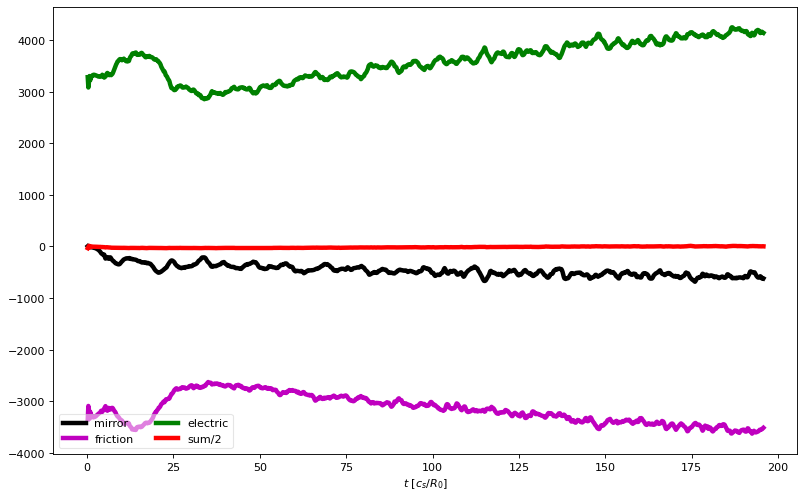

Invert for given numerical parameters
Resistivity = 3e-05
Average diff =  -59.57200107081225


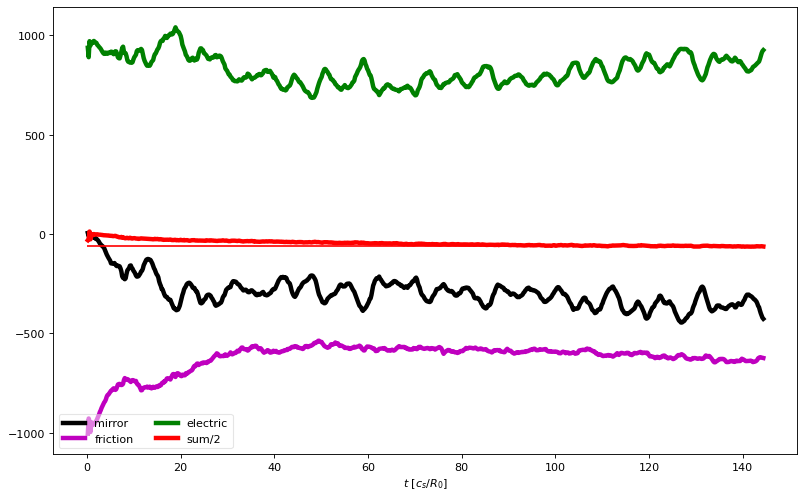

Invert for given numerical parameters
Resistivity = 3e-06
Average diff =  -71.3040361255576


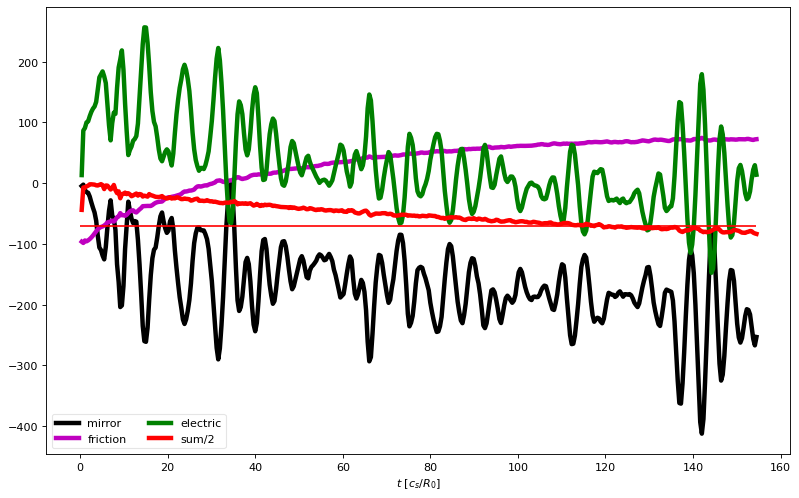

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -71.73504734036003


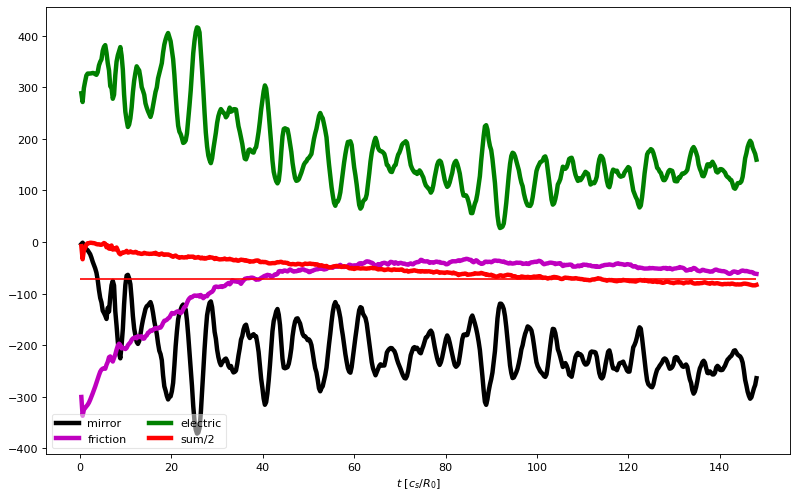

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  13.693364996759135


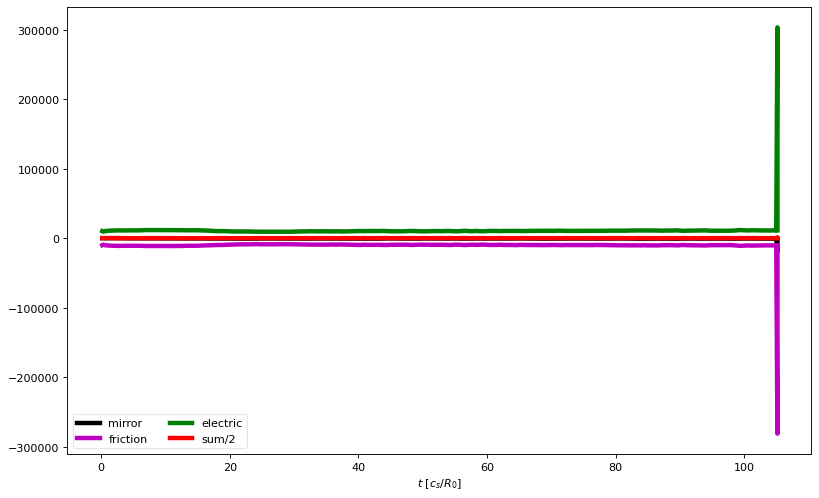

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -62.2878681241647


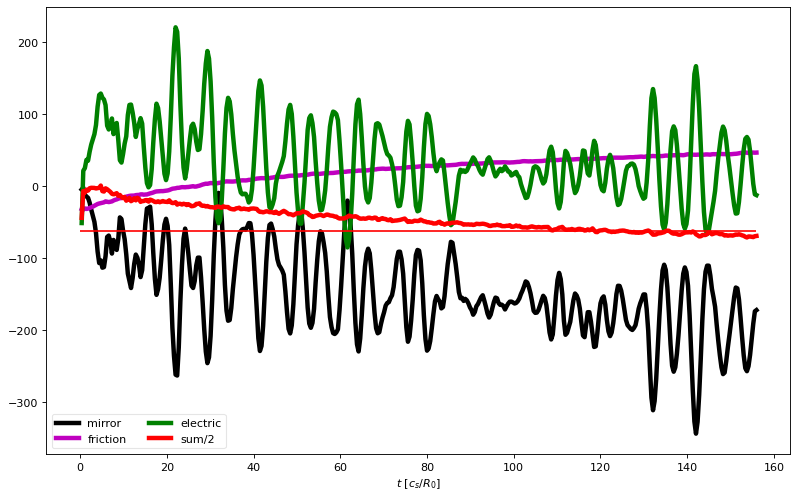

In [88]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(dset['sparmirrore_tt_ifs_lcfs'][:])/deltat
    mass+=np.asarray(dset['sparmirrorAe_tt_ifs_lcfs'][:])/deltat
    source =np.asarray(dset['friction_tt_ifs_lcfs'][:])/deltat

    jvne = np.asarray(dset['sparphie_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset['sparphiAe_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset['spardotAe_tt_ifs_lcfs'][:])/deltat
    lhs = mass + source
    rhs = jvne
    diff = (lhs + rhs)/2
    min_idx = min_idx_dict[params['physical']['resistivity']]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,mass[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="mirror")
    plt.plot(time[1:]*timescale,source[1:], color='m', marker='',
              ls='-', lw=2,markeredgecolor='m', markersize=8, label="friction")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="electric")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="sum/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )